<a href="https://colab.research.google.com/github/siming-deng/CIS3920_Data_Mining_for_Business_Analytics/blob/main/cis3920_project_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 7: Movie Recommendation Project
#### Team Members: Efaz Ahmed, Si Ming Deng, Jason Dong, Taohid Shadat

### Import libraries

In [ ]:
!pip install -U pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries for the recommendation system
import re
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from termcolor import colored
from wordcloud import WordCloud, STOPWORDS

import PIL
from PIL import Image
import urllib

import ast # To convert the string of list to list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')
pd.set_option('max_columns', None)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load primary datasets

In [ ]:
movies_df = pd.read_csv('/content/tmdb_5000_movies.csv', engine='python')
credits_df = pd.read_csv('/content/tmdb_5000_credits.csv', engine='python')

### Examine primary datasets

In [ ]:
# Checking movies data
print(list(movies_df.columns))
print(movies_df.shape)
movies_df.head(2)

['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']
(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [ ]:
# Checking credits data
print(list(credits_df.columns))
print(credits_df.shape)
credits_df.head(2)

['movie_id', 'title', 'cast', 'crew']
(4803, 4)


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
# Merging data
data = pd.merge(movies_df, credits_df, how = 'inner', left_on = ["id", "title"], right_on = ["movie_id", "title"])
data.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
data.shape

(4803, 23)

### Feature Selection

In [ ]:
# Columns we want to keep
# movie_id (credits), genres (movies), keywords (movies), title (movies),
# overview (movies), tagline (movies), cast(credits), crew(credits)

columns = [
    'movie_id',
    'title',
    'overview',
    'genres',
    'keywords',
    'cast',
    'crew',
  ]

data = data[columns]
data.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
# Checking for null values
data.isnull().sum()

movie_id     0
title        0
overview    31
genres       0
keywords     0
cast         0
crew         0
dtype: int64

### Explore null data

In [ ]:
# Display some of the rows where overview contained null values
data[data['overview'].isnull()].head(3)

,movie_id,title,overview,genres,keywords,cast,crew
65,155,The Dark Knight,NaN,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de..."
77,150540,Inside Out,NaN,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...","[{""cast_id"": 4, ""character"": ""Joy (voice)"", ""c...","[{""credit_id"": ""56098866c3a368681000003a"", ""de..."
94,118340,Guardians of the Galaxy,NaN,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...","[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."


### Load secondary dataset

In [ ]:
# It seems like we have 31 null values present in the overview column.
# Let's read this external csv so that we can provide movies without an
# overview with an appropriate one.
external_df = pd.read_csv('/content/tmdb_5000_movies_external.csv')
external_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


### Examine secondary dataset

In [ ]:
# Checking for null values
external_df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [ ]:
external_df.shape

(4803, 20)

In [ ]:
external_df[external_df['overview'].isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0
4431,913000,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,292539,[],de,Food Chains,NaN,0.795698,[],[],2014-04-26,0,83.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Food Chains,7.4,8


### Preprocessing (Handling null values)

In [ ]:
# There are only 3 null values in the overview column compared to the
# 31 null values presented originally.
# Let's replace these 3 null values with an empty string to reduce errors
external_df.fillna('', inplace=True)
external_df.isnull().sum()

budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [ ]:
# Defining function that replaces null values in the overview column
# with the data from the external csv.
def fill_overview(row, df):
    old_overview = row.iloc[2]
    if not old_overview:
        condition = df['id'] == row['movie_id']
        idx = df.index[condition].tolist()[0]
        new_overview = df.iloc[idx]['overview']
        row['overview'] = new_overview
    return row

data.fillna('', inplace=True)
data = data.apply(lambda row: fill_overview(row, external_df), axis=1)

In [ ]:
# Checking for null values again
data.isnull().sum()

movie_id    0
title       0
overview    0
genres      0
keywords    0
cast        0
crew        0
dtype: int64

### Explore data to see if null values were overwritten correctly

In [ ]:
# Let's check some of the rows that had null values in the overview column
data.iloc[[65, 77, 94]]

,movie_id,title,overview,genres,keywords,cast,crew
65,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de..."
77,150540,Inside Out,"Growing up can be a bumpy road, and it's no ex...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...","[{""cast_id"": 4, ""character"": ""Joy (voice)"", ""c...","[{""credit_id"": ""56098866c3a368681000003a"", ""de..."
94,118340,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...","[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...","[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."


### Defining Functions for Text Mining Preprocessing and Vectorization Techniques

In [ ]:
# Extract values ('name') from a dict
def convert(lst):
    values = []
    for i in ast.literal_eval(lst):
        values.append(i['name'])
    return values

# Get the director from the crew column
def get_director(text):
    res = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            res.append(i['name'])
    return res

# Remove spaces
def remove_spaces(lst):
    res = []
    for i in lst:
        res.append(i.replace(' ', ''))
    return res

# Remove punctuation
def remove_punc(text):
    res = re.sub(r'[^\w\s]', '', text)
    return res

# Get the length of literal lists/arrays
def get_count(lst):
    count = len(ast.literal_eval(lst))
    return [str(count)] # We are returning a list of a string for consistency

# Application of the Lemmatizer
def lemm(lst):
    res = []
    for i in lst:
        res.append(le.lemmatize(i))
    return res

### Feature Creation: director, cast_count, crew_count

In [ ]:
# Count how many names are in a cast/crew
data['cast_count'] = data['cast'].apply(get_count)
data['crew_count'] = data['crew'].apply(get_count)

# Let's use the get_director function to extract the director from the crew
data['director'] = data['crew'].apply(get_director)
data.drop(columns=['crew'], inplace=True)

data.head(1)

,movie_id,title,overview,genres,keywords,cast,cast_count,crew_count,director
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...",[83],[153],[James Cameron]


### Text Mining Processing Technique (Handling dirty features)

In [ ]:
# Let's use the convert function
data['genres'] = data['genres'].apply(convert)
data['keywords'] = data['keywords'].apply(convert)
data['cast'] = data['cast'].apply(convert)

data.head(1)

,movie_id,title,overview,genres,keywords,cast,cast_count,crew_count,director
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",[83],[153],[James Cameron]


### Text Mining Processing Technique (Tokenization)

In [ ]:
# Tokenization of the overview column
data['overview'] = data['overview'].apply(str.split)

data.head(1)

,movie_id,title,overview,genres,keywords,cast,cast_count,crew_count,director
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",[83],[153],[James Cameron]


### Text Mining Processing Technique (Lemmatizing)

In [ ]:
# Application of Lemmatizer
le = WordNetLemmatizer()
data['overview'] = data['overview'].apply(lemm)

data.head(1)

,movie_id,title,overview,genres,keywords,cast,cast_count,crew_count,director
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",[83],[153],[James Cameron]


In [ ]:
# Create a new column for all of our features
data['features'] = data['overview'] + data['genres'] + data['keywords'] +  data['cast'] + data['director'] + data['cast_count'] + data['crew_count']
data.head(1)

,movie_id,title,overview,genres,keywords,cast,cast_count,crew_count,director,features
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",[83],[153],[James Cameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."


In [ ]:
# Drop the other columns except for title
cols = ['overview', 'genres', 'keywords', 'cast', 'director', 'cast_count', 'crew_count']
new_data = data.drop(columns=cols).copy()
new_data.head(1)

,movie_id,title,features
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."


In [ ]:
# Join the list of out features in our 'features' column into 1 string
new_data['features'] = new_data['features'].apply(' '.join)
new_data.head(1)

,movie_id,title,features
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."


### Text Mining Processing Technique (Case Matching)

In [ ]:
# Lowercased the features string for consistency
new_data['features'] = new_data['features'].apply(str.lower)
new_data.head(1)

,movie_id,title,features
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."


### Text Mining Processing Technique (Removing Punctuation)

In [ ]:
# Removed punctuation
new_data['features'] = new_data['features'].apply(remove_punc)
new_data.head(1)

,movie_id,title,features
0,19995,Avatar,in the 22nd century a paraplegic marine is dis...


### Vectorization Technique (CountVectorizer, TfidfVectorizer)

In [ ]:
# Vectorize our features using CountVectorizer
cv = CountVectorizer(stop_words='english')
c_vectors = cv.fit_transform(new_data['features']).toarray()

# Vectorize our features using TfidfVectorizer
tv = TfidfVectorizer(analyzer='word', stop_words='english')
t_vectors = tv.fit_transform(new_data['features']).toarray()

### Similarity Measuring Techniques (cosine similarity, euclidean distances)

In [ ]:
# Find similarities between our vectors using cosine similarity
cv_cosine_similarity = cosine_similarity(c_vectors)
tv_cosine_similarity = cosine_similarity(t_vectors)

# Find distances between our vectors using euclidean distances
cv_euclidean_distances = euclidean_distances(c_vectors)
tv_euclidean_distances = euclidean_distances(t_vectors)

### Defining our recommendation function

In [ ]:
# Defining our recommendation function
def recommend(movie):
    # CountVectorizer and Cosine Similarity
    index = new_data[new_data['title'] == movie].index[0]
    distances = sorted(list(enumerate(cv_cosine_similarity[index])), reverse=True, key=lambda x: x[1])
    print('\033[96m', '   CountVectorizer | Cosine Similarity:', '\033[0m', sep='')
    for i, distance in enumerate(distances[1:6]):
        percentage = "\033[96m({:.0%})\033[0m".format(distance[1])
        print('      ', f"{i+1})", new_data.iloc[distance[0]].title, percentage)

    # TfidfVectorizer and Cosine Similarity
    index = new_data[new_data['title'] == movie].index[0]
    distances = sorted(list(enumerate(tv_cosine_similarity[index])), reverse=True, key=lambda x: x[1])
    print('\033[95m', '   TfidfVectorizer | Cosine Similarity:', '\033[0m', sep='')
    for i, distance in enumerate(distances[1:6]):
        percentage = "\033[95m({:.0%})\033[0m".format(distance[1])
        print('      ', f"{i+1})", new_data.iloc[distance[0]].title, percentage)

    # CountVectorizer and Euclidean Distances
    index = new_data[new_data['title'] == movie].index[0]
    distances = sorted(list(enumerate(cv_euclidean_distances[index])), reverse=False, key=lambda x: x[1])
    print('\033[94m', '   CountVectorizer | Euclidean Distances:', '\033[0m', sep='')
    for i, distance in enumerate(distances[1:6]):
        print('      ', f"{i+1})", new_data.iloc[distance[0]].title, f"\033[94m({round(distance[1], 2)})\033[0m")

    # TfidfVectorizer and Euclidean Distances
    index = new_data[new_data['title'] == movie].index[0]
    distances = sorted(list(enumerate(tv_euclidean_distances[index])), reverse=False, key=lambda x: x[1])
    print('\033[91m', '   TfidfVectorizer | Euclidean Distances:', '\033[0m', sep='')
    for i, distance in enumerate(distances[1:6]):
        print('      ', f"{i+1})", new_data.iloc[distance[0]].title, f"\033[91m({round(distance[1], 2)})\033[0m")

### Testing our model

In [ ]:
# Testing our model
movies = ['The Dark Knight', 'The Shawshank Redemption', 'Frozen']
print('\033[0mCosine Similarities \033[96mCOUNT(%)\033[95m TFIDF(%)\033[0m')
print('\033[0mEuclidean Distances \033[94mCOUNT(%)\033[91m TFIDF(%)\033[0m')
print('===================================================================')
for movie in movies:
    print('\033[93m', f"Recommendation for '{movie}'", '\033[0m', sep='')
    recommend(movie)
    print('===================================================================')

Cosine Similarities COUNT(%) TFIDF(%)
Euclidean Distances COUNT(%) TFIDF(%)
Recommendation for 'The Dark Knight'
   CountVectorizer | Cosine Similarity:
       1) The Dark Knight Rises (40%)
       2) Batman Begins (32%)
       3) Batman (28%)
       4) Pearl Harbor (28%)
       5) Wall Street (28%)
   TfidfVectorizer | Cosine Similarity:
       1) The Dark Knight Rises (21%)
       2) Batman Returns (20%)
       3) Batman Begins (19%)
       4) Batman (17%)
       5) Batman: The Dark Knight Returns, Part 2 (15%)
   CountVectorizer | Euclidean Distances:
       1) Batman (21.98)
       2) Batman: The Dark Knight Returns, Part 2 (22.27)
       3) Kill the Messenger (22.45)
       4) Mi America (22.47)
       5) In Too Deep (22.54)
   TfidfVectorizer | Euclidean Distances:
       1) The Dark Knight Rises (1.25)
       2) Batman Returns (1.27)
       3) Batman Begins (1.28)
       4) Batman (1.29)
       5) Batman: The Dark Knight Returns, Part 2 (1.3)
Recommendation for 'The Shawshank Re

### Defining Function to Get Words for WordCloud

In [ ]:
def get_words(movie, v_technique, sim_technique):
    if v_technique == 'cv' and sim_technique == 'cosine':
        index = new_data[new_data['title'] == movie].index[0]
        distances = sorted(list(enumerate(cv_cosine_similarity[index])), reverse=True, key=lambda x: x[1])[1:16]
        words = []
        for i, distance in enumerate(distances):
            title = new_data.iloc[distance[0]].title
            title = title.replace(' ', '')
            title = re.sub(r'[^\w\s]', '', title)
            temp = [title]*(int(distance[1]*100)**2)
            words.extend(temp)
        return ' '.join(words)

    if v_technique == 'tv' and sim_technique == 'cosine':
        index = new_data[new_data['title'] == movie].index[0]
        distances = sorted(list(enumerate(tv_cosine_similarity[index])), reverse=True, key=lambda x: x[1])[1:26]
        words = []
        for i, distance in enumerate(distances):
            title = new_data.iloc[distance[0]].title
            title = title.replace(' ', '')
            title = re.sub(r'[^\w\s]', '', title)
            temp = [title]*(int(distance[1]*100)**2)
            words.extend(temp)
        return ' '.join(words)

    if v_technique == 'cv' and sim_technique == 'euclidean':
        index = new_data[new_data['title'] == movie].index[0]
        distances = sorted(list(enumerate(cv_euclidean_distances[index])), reverse=False, key=lambda x: x[1])[1:16]
        words = []
        for i, distance in enumerate(distances):
            title = new_data.iloc[distance[0]].title
            title = title.replace(' ', '')
            title = re.sub(r'[^\w\s]', '', title)
            temp = [title]*((100-(int(distance[1])))**2)
            words.extend(temp)
        return ' '.join(words)

    if v_technique == 'tv' and sim_technique == 'euclidean':
        index = new_data[new_data['title'] == movie].index[0]
        distances = sorted(list(enumerate(tv_euclidean_distances[index])), reverse=False, key=lambda x: x[1])[1:16]
        words = []
        for i, distance in enumerate(distances):
            title = new_data.iloc[distance[0]].title
            title = title.replace(' ', '')
            title = re.sub(r'[^\w\s]', '', title)
            temp = [title]*((100-(int(distance[1]*10)))**2)
            words.extend(temp)
        return ' '.join(words)

### Create WordCloud and Setting Plot Parameters

In [ ]:
wordcloud = WordCloud(width = 2000, height = 2000,
                background_color ='black',
                colormap='Pastel1',
                collocations=False,
                scale=2,
                min_font_size = 20)

plt.rcParams["figure.figsize"] = [25, 25]

### Defining Function to show WordCloud with Image of Movie

In [ ]:
def show_wordclouds(movie, image_url, formatted_title=None):
    if not formatted_title:
        formatted_title = movie

    plt.subplot(1, 5, 1)
    plt.tick_params(left=False, bottom=False)
    plt.imshow(np.array(PIL.Image.open(urllib.request.urlopen(image_url)).resize((300,300), Image.Resampling.LANCZOS)))
    plt.axis("off")
    plt.title(f"{formatted_title}\n", fontsize=25, fontweight='bold')

    words = get_words(movie, 'cv', 'cosine')
    wordcloud.generate(words)
    plt.subplot(1, 5, 2)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('CountVectorizer\nand\nCosine Similarity', fontsize = 20, fontweight="bold", color='green')

    words = get_words(movie, 'tv', 'cosine')
    wordcloud.generate(words)
    plt.subplot(1, 5, 3)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('TfidfVectorizer\nand\nCosine Similarity', fontsize = 20, fontweight="bold", color='purple')

    words = get_words(movie, 'cv', 'euclidean')
    wordcloud.generate(words)
    plt.subplot(1, 5, 4)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('CountVectorizer\nand\nEuclidean Distances', fontsize = 20, fontweight="bold", color='blue')

    words = get_words(movie, 'tv', 'euclidean')
    wordcloud.generate(words)
    plt.subplot(1, 5, 5)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('TfidfVectorizer\nand\nEuclidean Distances', fontsize = 20, fontweight="bold", color='red')

### Displaying WordClouds

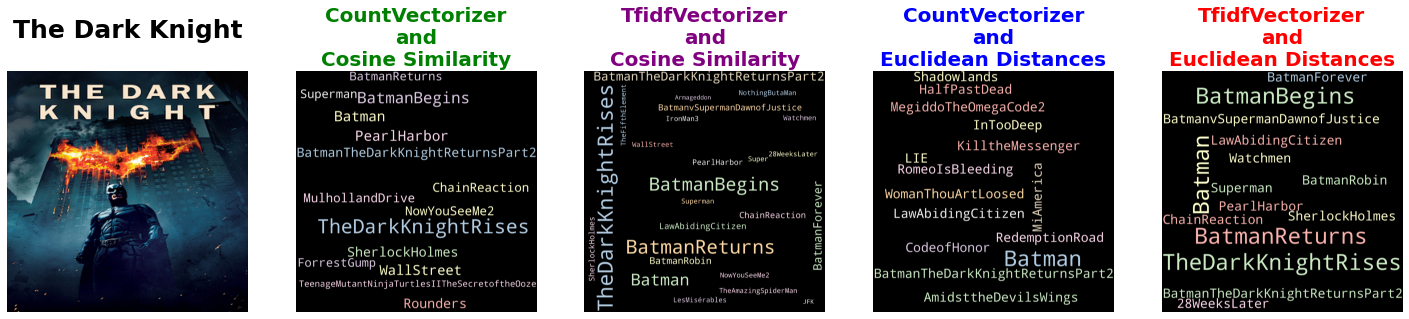

In [ ]:
image_url = 'https://play-lh.googleusercontent.com/qhfncXOqccJ5Y_IBPaRy0O79QZQDl7L5FyKQAsLFICt8c9-2Vfmqd2bniAPESto0ZmSLTOzjl-o1F_jgb2Nr'
show_wordclouds('The Dark Knight', image_url)

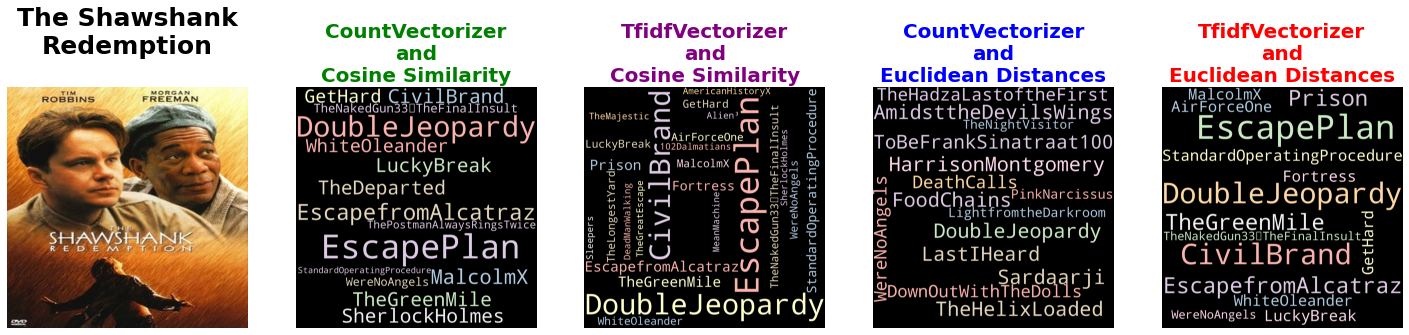

In [ ]:
image_url = 'https://movieposters2.com/images/630257-b.jpg'
show_wordclouds('The Shawshank Redemption', image_url, 'The Shawshank\nRedemption')

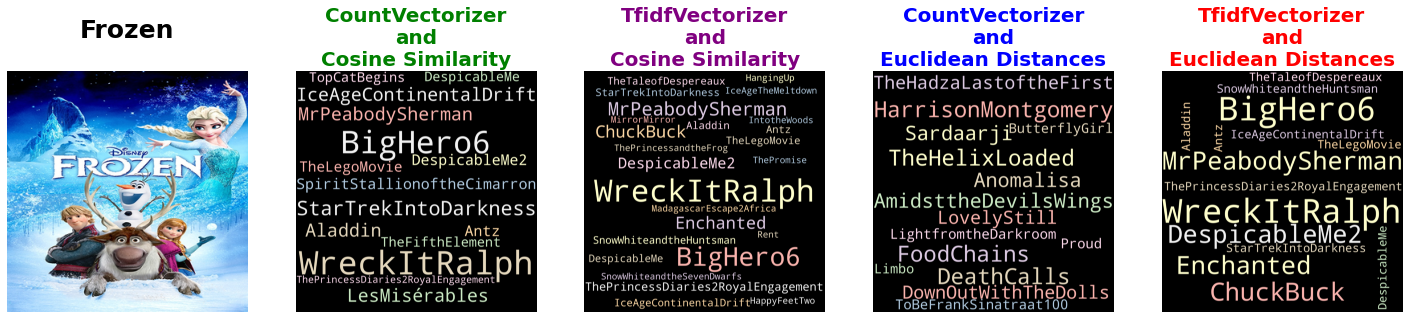

In [ ]:
image_url = 'https://lumiere-a.akamaihd.net/v1/images/p_frozen_18373_3131259c.jpeg'
show_wordclouds('Frozen', image_url)